# En el presente notebook se tieme el modelamiento de tópicos utilizando dos técnicas

1. Modelamiento de clusterización DBSCAN
2. Modelamiento LDA

## Instalación de librerías

* NLTK: Librería para procesamiento de texto
* wordcloud: Librería para imprimir nube de pálabras
* gensim: Librería que contiene modelos de Asignación Latente de Dirichlet (LDA)
* pyLDAvis: Librería para generar la visualización de los clusters encontrados
* FastText: Librería de Facebook para generar embedding

Las demás librerías que son usuales para manipulación de datos o modelamiento ya se encontraban instaladas en el ambiente de anaconda local

In [1]:
!pip install nltk

1314.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 17.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [18]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 15.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 9.7 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=89b47bfafae7dc0afa6bb75c2bcc6db098186efbe2dc1752346de094ca263b6d
  Stored in directory: /home/sheldor/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=fcba3ee0505250b46e1e365129231817307c7965d5728947fa22a6553b4bb903
  Stored in directory: /home/sheldor/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built pyLDAvis sklearn

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4689446 sha256=f9edf22fbed7ff5662c6e89cc1d84943f324318232fa6a60be305b7841270084
  Stored in directory: /home/sheldor/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
import re 
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import fasttext
import fasttext.util

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models


import plotly.express as px
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
plotly.offline.init_notebook_mode(connected=True)

/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Lectura y exploración del dataframe

In [2]:
data = pd.read_csv('../Data/davivienda_tweets.csv')
data

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...
...,...,...,...,...,...,...,...,...,...,...,...,...
1806,1806,Banco Davivienda,@Davivienda,2021-12-22T18:26:38.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737216...
1807,1807,Banco Davivienda,@Davivienda,2021-12-22T20:18:40.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@josefe71\nHola Jose , gracia...",NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737498...
1808,1808,Banco Davivienda,@Davivienda,2021-12-22T17:54:45.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,👋,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14737136...
1809,1809,Banco Davivienda,@Davivienda,2021-12-22T11:45:13.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",NaN,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14736206...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1811 entries, 0 to 1810
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1811 non-null   int64  
 1   UserScreenName  1807 non-null   object 
 2   UserName        1811 non-null   object 
 3   Timestamp       1811 non-null   object 
 4   Text            1811 non-null   object 
 5   Embedded_text   1811 non-null   object 
 6   Emojis          295 non-null    object 
 7   Comments        838 non-null    float64
 8   Likes           247 non-null    object 
 9   Retweets        643 non-null    object 
 10  Image link      1811 non-null   object 
 11  Tweet URL       1811 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 169.9+ KB


In [8]:
data = data.fillna(0)

In [12]:
data['Likes'].value_counts()

0          1564
1           143
2            58
3            12
4             6
6             5
7             4
5             4
10            2
19            1
29            1
11            1
16            1
14            1
838           1
15            1
1,5 mil       1
115           1
9             1
8             1
326           1
13            1
Name: Likes, dtype: int64

In [15]:
data[data['Likes']=='1,5 mil']

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
1134,1134,Wilson Arias,@wilsonariasc,2021-12-17T10:20:00.000Z,Wilson Arias\n@wilsonariasc\n·\n17 dic.,He conocido de primera mano un caso en el que ...,0,87.0,"1,5 mil","2,5 mil",[],https://twitter.com/wilsonariasc/status/147178...


In [16]:
data[data['Likes']=='838']

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
779,779,Maria Niny Echeverry,@Marianiniecheve,2021-12-15T19:01:12.000Z,Maria Niny Echeverry\n@Marianiniecheve\n·\n15 ...,Chicos: me ayudarían a denunciar a \n@SegurosB...,😡 😡 😡,65.0,838,1 mil,[],https://twitter.com/Marianiniecheve/status/147...


In [17]:
data['Retweets'].value_counts()

0          1168
1           343
2           126
3            48
4            36
5            16
6            10
7             9
11            7
14            6
9             6
8             5
10            3
13            3
19            3
23            2
25            2
20            1
1 mil         1
855           1
12            1
252           1
2,5 mil       1
17            1
18            1
48            1
123           1
60            1
16            1
15            1
43            1
38            1
89            1
171           1
24            1
Name: Retweets, dtype: int64

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sheldor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Modelo de clustering con DBSCAN basado en la creación de embeddings con fasttext (Facebook)

#### Lectura del modelo fastText descargado
Ejecutar la siguiente celda unicamente la primera vez para descargar el modelo en español cc.es.300.bin

In [21]:
# fasttext.util.download_model('es', if_exists='ignore')  # Ejecutar unicamente la primera vez para descargar el modelo en español cc.es.300.bin
model_embeddings = fasttext.load_model('cc.es.300.bin')

### Función para la limpieza de textos

* Eliminación de carácteres especiales, números, "respuesta"
* Tokenización del texto
* Eliminación de stopwords en español
* Lematización de pálabras

Se tienen dos funciones: 
1. Función sin devolver el texto dentro de una lista de Python para modelamiento de clusterización DBSCAN
2. Función dos devuelve el texto dentro de una lista de Python para modelamiento LDA

In [22]:
def limpiado_de_texto_1(texto, remove_stop_words=True, stemming_words=True):
    
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # remover numeros
    texto = re.sub(r'\b\d+(?:\.\d+)?\s+', '', texto)
    texto = re.sub('respuesta', '', texto)  # Se elimina la palabra respuesta debido a que se observa ser una pálabra frecuente utilizada por la cuenta de Davivienda
    texto = re.sub('Respuesta', '', texto)  
    texto = re.sub('1', '', texto) 
    texto = re.sub('2', '', texto) 
    # Convertimos textos a minusculas
    texto = texto.lower()
    
    # Tokenizado
    tokenizer = ToktokTokenizer() 
    tokens = tokenizer.tokenize(texto)
    
    # Eliminacion de stopwords
    stop_words =  stopwords.words('spanish')
    if remove_stop_words:
        tokens = [w for w in tokens if not w in stop_words]

    # Stemming
    stemmer = SnowballStemmer("spanish") 
    if stemming_words:
        tokens = [stemmer.stem(token) for token in tokens]
    
    text = " ".join(tokens)
 
    return(text)

def limpiado_de_texto_2(texto, remove_stop_words=True, stemming_words=True):
    
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # remover numeros
    texto = re.sub(r'\b\d+(?:\.\d+)?\s+', '', texto) 
    texto = re.sub('respuesta', '', texto)  
    texto = re.sub('Respuesta', '', texto)  
    texto = re.sub('1', '', texto) 
    texto = re.sub('2', '', texto) 
    # Convertimos textos a minusculas
    texto = texto.lower()
    
    # Tokenizado
    tokenizer = ToktokTokenizer() 
    tokens = tokenizer.tokenize(texto)
    
    # Eliminacion de stopwords
    stop_words =  stopwords.words('spanish')
    if remove_stop_words:
        tokens = [w for w in tokens if not w in stop_words]

    # Stemming
    stemmer = SnowballStemmer("spanish") 
    if stemming_words:
        tokens = [stemmer.stem(token) for token in tokens]
    
 
    return(tokens)

## Aplicación del model embedding de facebook
Se obtiene un vector de salida con la relación númerica entre las pálabras (embeddings)

In [23]:
vector_emmbeding = []

for index, row in tqdm(data.iterrows()):
    
    vector_emmbeding.append(model_embeddings.get_sentence_vector(limpiado_de_texto_1(row['Embedded_text'],stemming_words= False)).tolist())

1811it [00:00, 2926.95it/s]


### Escalamiento de datos y reducción de dimensionalidad para visualizar los embeddings

In [24]:
vector_scaled = StandardScaler().fit_transform(np.array(vector_emmbeding))

data['embedding'] = vector_scaled.tolist()

comentarios_2d = TSNE(n_components=2).fit_transform(np.array(list(data['embedding'])))
comentarios_3d = TSNE(n_components=3).fit_transform(np.array(list(data['embedding'])))

/home/sheldor/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/sheldor/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/sheldor/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/sheldor/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [25]:
data['x'] = comentarios_3d[:,0]
data['y'] = comentarios_3d[:,1]
data['z'] = comentarios_3d[:,2]

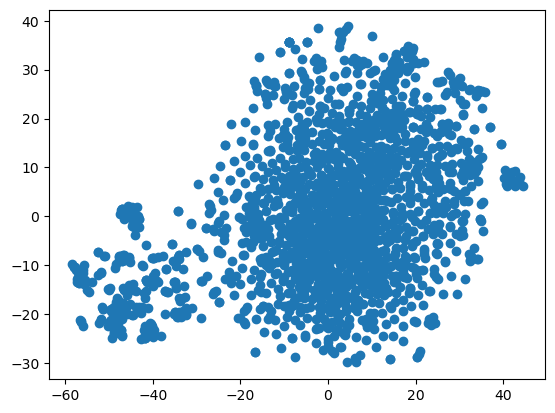

In [26]:
plt.scatter(comentarios_2d[:,0], comentarios_2d[:,1])
plt.show()

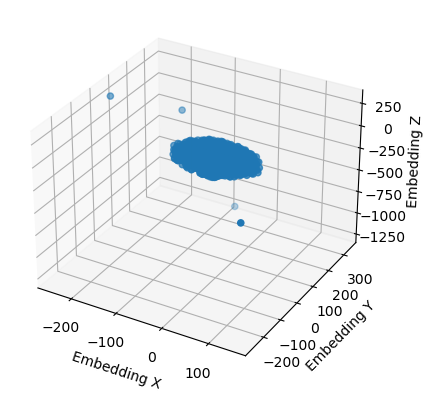

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data['x'], data['y'], data['z'])

ax.set_xlabel('Embedding X')
ax.set_ylabel('Embedding Y')
ax.set_zlabel('Embedding Z')

plt.show()

# Modelo DBSCAN

In [28]:
model_segmentacion = DBSCAN(eps=0.44, min_samples=19, metric='cosine')
clusters_data = model_segmentacion.fit_predict(np.array(list(data['embedding'])))
print(metrics.silhouette_score(np.array(list(data['embedding'])), clusters_data))

0.02626512580807813


In [29]:
data["cluster"] = list(map(chr,clusters_data+65))

## Generación de html interactivo con los clusters generados

In [30]:
def generete_random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 


def generete_random_symbol():
    list_of_symbols = [ "circle" , "circle-open" , "cross" , "diamond" , "diamond-open" , "square" , "square-open" , "x" ]
    return random.choice(list_of_symbols)
    

def encode_clusters_symbol(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_symbol()})
    
    cluster_encoded = []

    for cluster in list_of_clusters:
        cluster_encoded.append(dict_cluster_value.get(cluster))
        
    return cluster_encoded


def encode_clusters_color(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_color()})
        
    cluster_encoded = []
    
    for cluster in list_of_clusters:
        cluster_encoded.append(dict_cluster_value.get(cluster))
        
    return cluster_encoded


def clusters_color(list_of_clusters):
    
    unique_clusters = set(list_of_clusters)
    dict_cluster_value = {}
    
    for cluster_symbol in unique_clusters:
        dict_cluster_value.update({cluster_symbol : generete_random_color()})
        
    return dict_cluster_value

In [31]:
def plot_scatter_3d(dataframe, map_html = 'test.html'):
    
    unique_clusters = list(set(list(dataframe['cluster'])))
    unique_clusters.sort()
    
    dict_color = clusters_color(list(dataframe['cluster']))
    
    
    buffer = dataframe.loc[dataframe['cluster'] == unique_clusters[0]]
    
    
    fig = go.Figure(
            data=[
                go.Scatter3d(
                    x=buffer.x, 
                    y=buffer.y, 
                    z=buffer.z,
                    name='Cluster '+ unique_clusters[0],
                    hovertemplate='%{text}',
                    text = [title for title in buffer.Embedded_text],
                    mode='markers',
                    marker=dict(
                        size=8,
                        opacity=0.5,
                        color = dict_color.get(unique_clusters[0]) 
                    )
                )
            ]
        )
    
    
    for i in range(1, len(unique_clusters)):
        
        buffer = dataframe.loc[dataframe['cluster'] == unique_clusters[i]]

        fig.add_trace(
                            go.Scatter3d(
                                x=buffer.x, 
                                y=buffer.y, 
                                z=buffer.z,
                                name='Cluster '+ unique_clusters[i],
                                hovertemplate='%{text}',
                                text = [title for title in buffer.Embedded_text],
                                mode='markers',
                                marker=dict(
                                    size=8,
                                    opacity=0.5,
                                    color = dict_color.get(unique_clusters[i]) 
                                )
                            )
                        
                    
                )
        
        
    
    fig.update_traces(showlegend=True)
    fig.show()
    fig.write_html(map_html)

# Gráfico interactivo ("test.html")

In [32]:
plot_scatter_3d(data)

/home/sheldor/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/sheldor/anaconda3/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Modelamiento LDA 

In [33]:
data['Tokens'] = data.Embedded_text.apply(limpiado_de_texto_2)
data.head(2)

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,embedding,x,y,z,cluster,Tokens
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,0,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,"[0.31063381703032045, -0.6890017766029443, -2....",-24.763206,42.264782,-33.383801,@,"[confianz, afect, indic, confianz, daviviend, ..."
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,0.0,0,0,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...,"[1.1279594262155328, -1.1336724119261876, 1.71...",3.902002,41.852219,32.613670,@,"[busc, accesibil, mejor, atencion, tramit, ban..."


# Creación de diccionario y corpues para entrenamiento

In [34]:
diccionario = Dictionary(data.Tokens)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 4526


In [35]:
diccionario.filter_extremes(no_below=2, no_above = 0.8)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 2038


In [36]:
corpus = [diccionario.doc2bow(t) for t in data.Tokens]
print(corpus[6])

[(95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1)]


In [37]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=6, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [38]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(0, '0.058*"mensaj" + 0.052*"buen" + 0.048*"priv" + 0.044*"atent" + 0.043*"qued"')
(1, '0.030*"solucion" + 0.027*"daviplat" + 0.019*"cuent" + 0.013*"problem" + 0.012*"llev"')
(2, '0.014*"navid" + 0.013*"app" + 0.010*"hac" + 0.010*"com" + 0.010*"usted"')
(3, '0.022*"diner" + 0.021*"si" + 0.017*"banc" + 0.015*"respond" + 0.013*"cajer"')
(4, '0.025*"lug" + 0.023*"equivoc" + 0.012*"hac" + 0.012*"com" + 0.011*"daviplat"')
(5, '0.024*"respond" + 0.021*"banc" + 0.018*"hac" + 0.014*"cuent" + 0.010*"marianiniechev"')


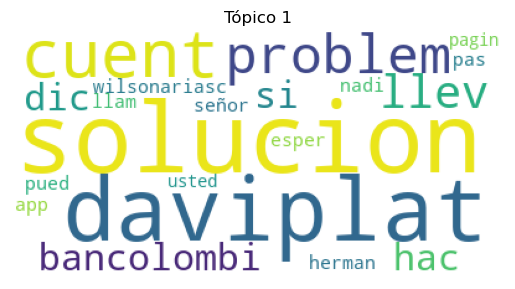

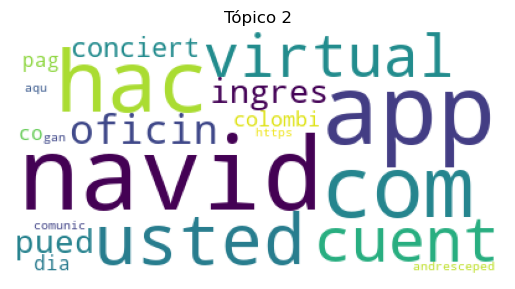

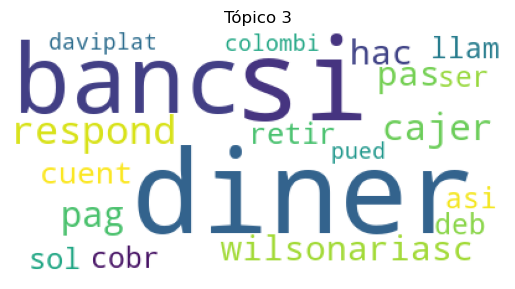

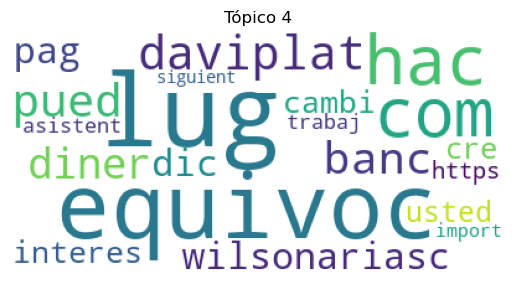

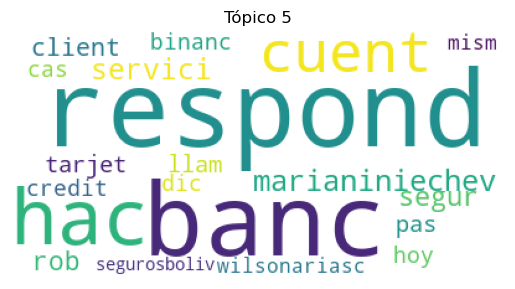

In [39]:
for i in range(1, 6):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [40]:
indice_noticia = random.randint(0,len(data))
bow_noticia = corpus[indice_noticia]
distribucion_noticia = lda[bow_noticia]

# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda[bow_noticia]]
# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda[bow_noticia]]

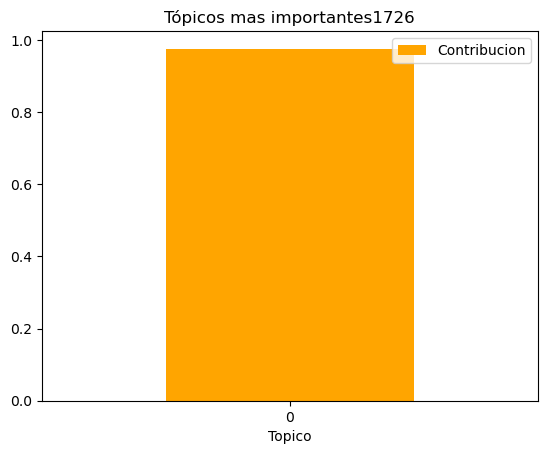

In [45]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   + str(indice_noticia))

In [42]:
for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 0 ***
mensaj, buen, priv, atent, qued, cas, favor, tard, valid, gust 



In [43]:
coherence_model_lda=CoherenceModel(model=lda,texts=data['Tokens'],dictionary=diccionario,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.4613704776278638


In [44]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda,corpus,diccionario)
vis

/home/sheldor/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the im

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.095511 -0.037638       1        1  21.955411
0     -0.407094 -0.017828       2        1  20.743578
1      0.106502 -0.118949       3        1  19.819961
3      0.100122 -0.060773       4        1  16.400948
2      0.037881  0.023475       5        1  11.444359
4      0.067077  0.211713       6        1   9.635741, topic_info=       Term        Freq       Total Category  logprob  loglift
274  mensaj  285.000000  285.000000  Default  30.0000  30.0000
553    priv  234.000000  234.000000  Default  29.0000  29.0000
548   atent  218.000000  218.000000  Default  28.0000  28.0000
362    qued  217.000000  217.000000  Default  27.0000  27.0000
129    buen  282.000000  282.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
444     vez    9.164741   25.557597   Topic6  -5.5141   1.3141
287   usted   12.236299   96.116949   Topic6  -5.2250   0.2785
78   import   10.575603   63.207165   Topic6  -5.3709   0.5518
107  trabaj   10.979005   85.700112   Topic6  -5.3335   0.2848
355  siempr    9.403058   37.733948   Topic6  -5.4884   0.9502

[399 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
170       1  0.421456             3
170       2  0.081049             3
170       3  0.145889             3
170       4  0.145889             3
170       5  0.129679             3
...     ...       ...           ...
1866      1  0.217276  wilsonariasc
1866      3  0.344644  wilsonariasc
1866      4  0.314675  wilsonariasc
1866      6  0.119876  wilsonariasc
783       5  0.815735         youtu

[708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 4, 3, 5])

In [46]:
lda_4 = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=4, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [47]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_4,corpus,diccionario)
vis

/home/sheldor/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the im

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.126254 -0.068593       1        1  29.389393
1      0.126395 -0.086147       2        1  27.149882
0     -0.349313 -0.010294       3        1  23.037276
2      0.096665  0.165033       4        1  20.423449, topic_info=           Term        Freq       Total Category  logprob  loglift
274      mensaj  282.000000  282.000000  Default  30.0000  30.0000
553        priv  231.000000  231.000000  Default  29.0000  29.0000
548       atent  215.000000  215.000000  Default  28.0000  28.0000
111       favor  212.000000  212.000000  Default  27.0000  27.0000
362        qued  214.000000  214.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
126  bancolombi   21.240269  106.196354   Topic4  -5.4247  -0.0209
92           si   22.267791  169.128150   Topic4  -5.3775  -0.4390
244         cre   17.449626   46.904502   Topic4  -5.6213   0.5997
214         dia   17.525202  109.156918   Topic4  -5.6170  -0.2407
179         hoy   16.479872   49.858212   Topic4  -5.6785   0.4814

[273 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
170       1  0.356081             3
170       2  0.242783             3
170       3  0.080928             3
170       4  0.307525             3
122       2  0.919921             6
...     ...       ...           ...
293       2  0.881755           web
1866      1  0.328140  wilsonariasc
1866      2  0.589161  wilsonariasc
1866      3  0.022373  wilsonariasc
1866      4  0.052204  wilsonariasc

[412 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [48]:
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values

In [49]:
num_topics_range= [2,6,10,15,20]
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=diccionario,corpus=corpus,texts=data['Tokens'],\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)

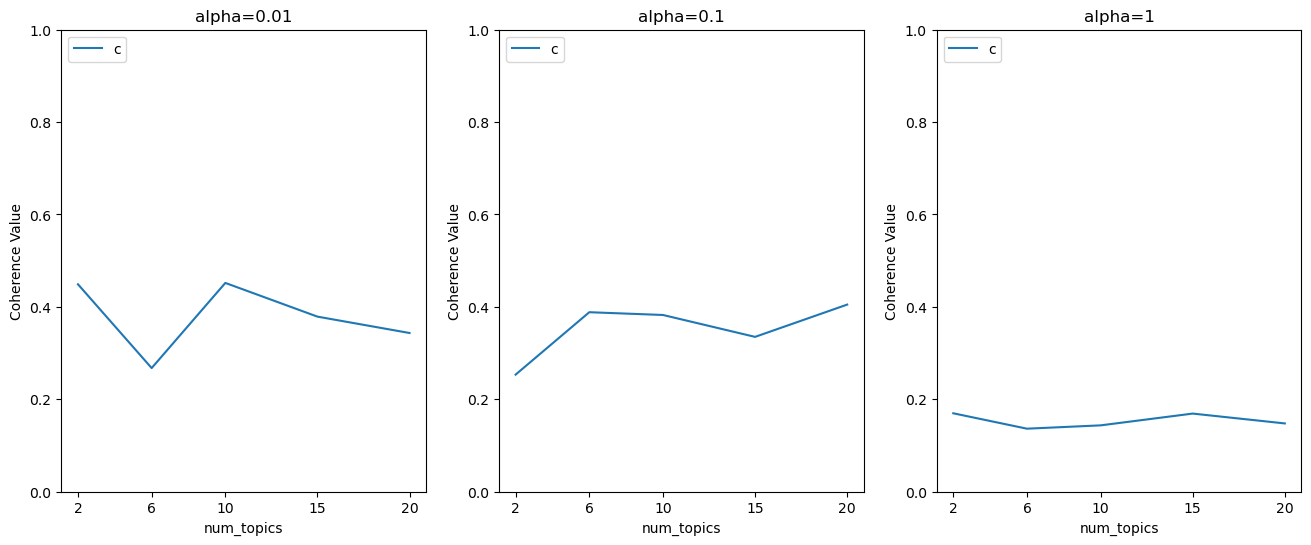

In [50]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])

def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df,alpha_range,num_topics_range)

In [51]:
lda_6 = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=3, random_state=42, 
               chunksize=1000, passes=10, alpha=0.01)

In [52]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_6,corpus,diccionario)
vis

/home/sheldor/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sheldor/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the im

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.134812 -0.101322       1        1  42.844674
2     -0.142662  0.099429       2        1  32.914664
0      0.277473  0.001893       3        1  24.240662, topic_info=        Term        Freq       Total Category  logprob  loglift
274   mensaj  276.000000  276.000000  Default  30.0000  30.0000
553     priv  224.000000  224.000000  Default  29.0000  29.0000
548    atent  209.000000  209.000000  Default  28.0000  28.0000
362     qued  208.000000  208.000000  Default  27.0000  27.0000
129     buen  274.000000  274.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1175    quer   47.274945   60.299082   Topic3  -4.7960   1.1738
11     mejor   62.615858   90.119067   Topic3  -4.5150   1.0530
33      dias   69.908318  125.175293   Topic3  -4.4048   0.8346
107   trabaj   50.668469   84.648984   Topic3  -4.7267   0.9039
37       pod   50.765050   94.688914   Topic3  -4.7248   0.7937

[199 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
170       1  0.306523             3
170       2  0.596913             3
170       3  0.096797             3
985       3  0.973338       acompañ
345       1  0.968843      actualiz
...     ...       ...           ...
287       3  0.010159         usted
1047      3  0.998117         valid
1866      1  0.487480  wilsonariasc
1866      2  0.472708  wilsonariasc
1866      3  0.044316  wilsonariasc

[285 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

#### Guardar modelo y diccionario

In [53]:
lda_6.save("Modelamiento_Topicos.model")
diccionario.save("articulos.dictionary")

# Generación de predicciones

In [68]:
prueba = data['Tokens'][894]

new_text_corpus =  diccionario.doc2bow(prueba)
lda_6.get_document_topics(new_text_corpus)
#lda_6[new_text_corpus]

[(1, 0.4109506), (2, 0.5870609)]

In [94]:
def predicciones_topico(Tokens):

    new_text_corpus =  diccionario.doc2bow(Tokens)

    lista_probabilidades = lda_6.get_document_topics(new_text_corpus)

    mayor = 0

    tupla_mayor = ()

    for i in lista_probabilidades:

        mayor_i = i[1]

        if mayor_i > mayor:
            mayor = mayor_i
            tupla_mayor = i
    
    probabilidad = tupla_mayor[1]
    topico = tupla_mayor[0]

    return topico, probabilidad

def get_topico(Tokens):

    return predicciones_topico(Tokens)[0]


def get_probabilidad(Tokens):

    return predicciones_topico(Tokens)[1]

In [86]:
prueba = data['Tokens'][894]

probabilidad = predicciones_topico(prueba)[0]

In [95]:
data['Topico'] = data.Tokens.apply(get_topico)
data['Probabilidad'] = data.Tokens.apply(get_probabilidad)

In [108]:
data_salida = data[['Embedded_text', 'Topico', 'Probabilidad', 'Likes', 'Retweets']]
data_salida

,Embedded_text,Topico,Probabilidad,Likes,Retweets
0,La confianza se afectó. El indicador de confia...,2,0.999049,7,19
1,Buscamos la accesibilidad y mejor atención en ...,2,0.998669,0,0
2,Señores \n@Davivienda\n no he podido ingresar ...,1,0.998465,0,1
3,Llevo toda una semana sufriendo intento de hur...,1,0.999001,1,2
4,Hemos retrocedido tanto en este país con este ...,2,0.998337,0,8
...,...,...,...,...,...
1806,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,0,0.998949,0,0
1807,"En respuesta a \n@josefe71\nHola Jose , gracia...",0,0.999260,0,0
1808,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,0,0.998949,0,0
1809,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",0,0.998826,0,0


# Generación Insights

In [128]:
def arreglar_miles(x):
    if type(x) == float or type(x) == int:
        return x
    if 'mil' in x:
        if len(x) > 1:
            arreglado = x.replace(' mil', '00')
            arreglado = arreglado.replace(',', '')
            return arreglado
    else:
        return x


data_salida['Likes_n']  = data.Likes.apply(arreglar_miles).astype(float)
data_salida['Retweets_n'] = data.Retweets.apply(arreglar_miles).astype(float)

data_salida['Interacciones'] = data_salida['Likes_n']+data_salida['Retweets_n']

data_salida['Insights'] = [1 if x > 100 else 0 for x in data_salida['Interacciones']]

/tmp/ipykernel_19748/3642969563.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19748/3642969563.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19748/3642969563.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [129]:
data_salida[data_salida['Insights']==1]

,Embedded_text,Topico,Probabilidad,Likes,Retweets,Likes_n,Retweets_n,Interacciones,Insights
51,Cada vez que me encuentro a Willington Ortíz l...,2,0.753295,16,171,16.0,171.0,187.0,1
217,– Hoy hace un año. \n¡Morat presentaba el conc...,2,0.998006,19,89,19.0,89.0,108.0,1
536,Gran concierto de Navidad \n@Davivienda\n \nht...,2,0.997155,14,123,14.0,123.0,137.0,1
779,Chicos: me ayudarían a denunciar a \n@SegurosB...,2,0.673530,838,1 mil,838.0,100.0,938.0,1
1134,He conocido de primera mano un caso en el que ...,2,0.999132,"1,5 mil","2,5 mil",1500.0,2500.0,4000.0,1
1137,Urge re estructuración al interior del \n@CeDe...,2,0.998825,115,252,115.0,252.0,367.0,1
1731,"Fajardo no hace con alianza con Petro porque, ...",2,0.999001,326,855,326.0,855.0,1181.0,1


# Generación de funcionalidad para predecir (cualquier dataset)

In [137]:
from gensim import  models

lda_cargado = models.ldamodel.LdaModel.load("Modelamiento_Topicos.model")

def predicciones_topico(Tokens):

    new_text_corpus =  diccionario.doc2bow(Tokens)

    lista_probabilidades = lda_cargado.get_document_topics(new_text_corpus)

    mayor = 0

    tupla_mayor = ()

    for i in lista_probabilidades:

        mayor_i = i[1]

        if mayor_i > mayor:
            mayor = mayor_i
            tupla_mayor = i
    
    probabilidad = tupla_mayor[1]
    topico = tupla_mayor[0]

    return topico, probabilidad

def get_topico(Tokens):

    return predicciones_topico(Tokens)[0]


def get_probabilidad(Tokens):

    return predicciones_topico(Tokens)[1]

def funcion_final(df,col_text):
    
    df['Tokens'] = df[col_text].apply(limpiado_de_texto_2)
    df['Topico'] = df.Tokens.apply(get_topico)
    df['Probabilidad'] = df.Tokens.apply(get_probabilidad)

    df = df[['Embedded_text', 'Topico', 'Probabilidad', 'Likes', 'Retweets']]

    df['Likes_n']  = data.Likes.apply(arreglar_miles).astype(float)
    df['Retweets_n'] = data.Retweets.apply(arreglar_miles).astype(float)

    df['Interacciones'] = df['Likes_n']+df['Retweets_n']

    df['Insights'] = [1 if x > 100 else 0 for x in df['Interacciones']]

    return df

df_predicciones = funcion_final(data,'Embedded_text')

/tmp/ipykernel_19748/2260804585.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19748/2260804585.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19748/2260804585.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

In [138]:
df_predicciones

,Embedded_text,Topico,Probabilidad,Likes,Retweets,Likes_n,Retweets_n,Interacciones,Insights
0,La confianza se afectó. El indicador de confia...,2,0.999049,7,19,7.0,19.0,26.0,0
1,Buscamos la accesibilidad y mejor atención en ...,2,0.998669,0,0,0.0,0.0,0.0,0
2,Señores \n@Davivienda\n no he podido ingresar ...,1,0.998465,0,1,0.0,1.0,1.0,0
3,Llevo toda una semana sufriendo intento de hur...,1,0.999001,1,2,1.0,2.0,3.0,0
4,Hemos retrocedido tanto en este país con este ...,2,0.998337,0,8,0.0,8.0,8.0,0
...,...,...,...,...,...,...,...,...,...
1806,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,0,0.998949,0,0,0.0,0.0,0.0,0
1807,"En respuesta a \n@josefe71\nHola Jose , gracia...",0,0.999260,0,0,0.0,0.0,0.0,0
1808,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,0,0.998949,0,0,0.0,0.0,0.0,0
1809,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",0,0.998826,0,0,0.0,0.0,0.0,0


In [139]:
df_predicciones[df_predicciones['Insights']==1]

,Embedded_text,Topico,Probabilidad,Likes,Retweets,Likes_n,Retweets_n,Interacciones,Insights
51,Cada vez que me encuentro a Willington Ortíz l...,2,0.753310,16,171,16.0,171.0,187.0,1
217,– Hoy hace un año. \n¡Morat presentaba el conc...,2,0.998006,19,89,19.0,89.0,108.0,1
536,Gran concierto de Navidad \n@Davivienda\n \nht...,2,0.997155,14,123,14.0,123.0,137.0,1
779,Chicos: me ayudarían a denunciar a \n@SegurosB...,2,0.673537,838,1 mil,838.0,100.0,938.0,1
1134,He conocido de primera mano un caso en el que ...,2,0.999132,"1,5 mil","2,5 mil",1500.0,2500.0,4000.0,1
1137,Urge re estructuración al interior del \n@CeDe...,2,0.998825,115,252,115.0,252.0,367.0,1
1731,"Fajardo no hace con alianza con Petro porque, ...",2,0.999001,326,855,326.0,855.0,1181.0,1


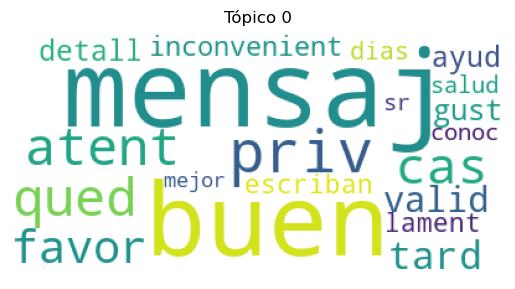

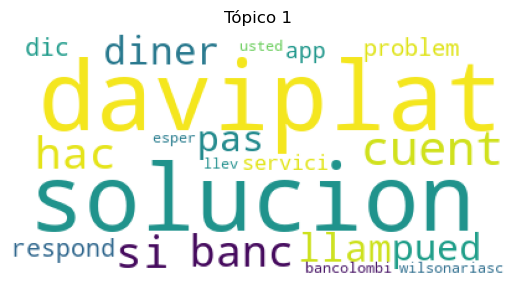

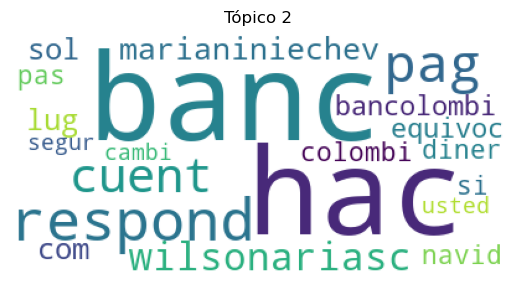

In [141]:
for i in range(0, 3):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda_cargado.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

<AxesSubplot:>

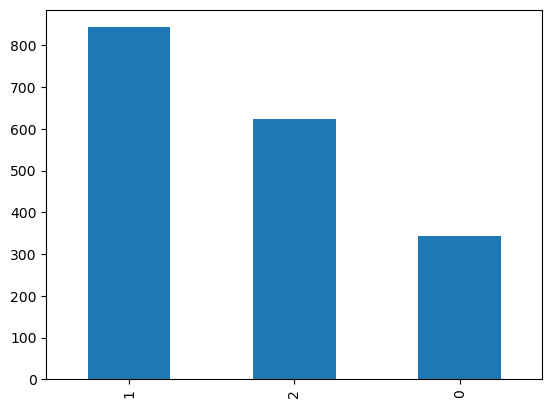

In [142]:
df_predicciones['Topico'].value_counts().plot(kind="bar")

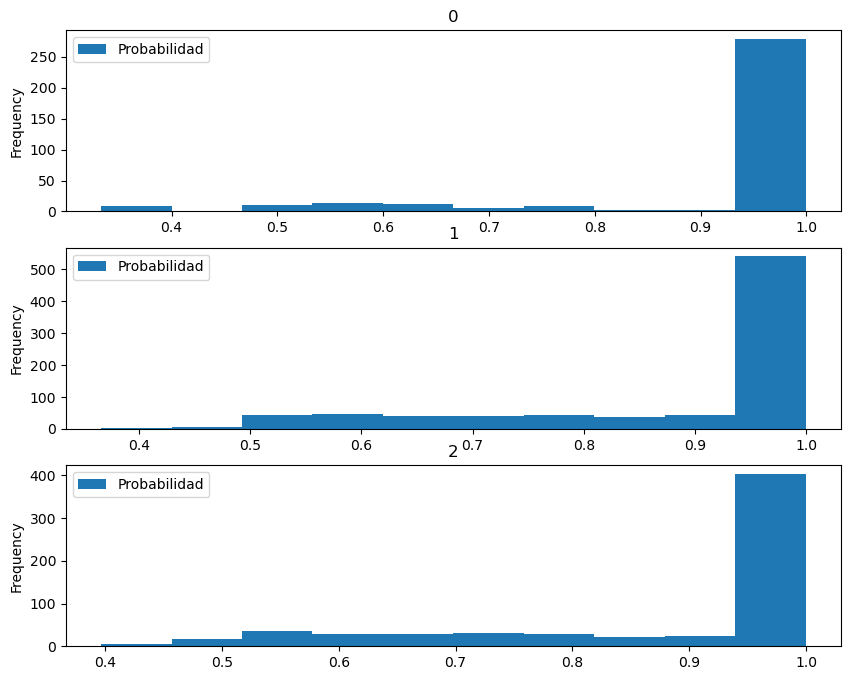

In [143]:
ax = df_predicciones.plot.hist(column=["Probabilidad"], by="Topico", figsize=(10, 8))

<AxesSubplot:ylabel='Frequency'>

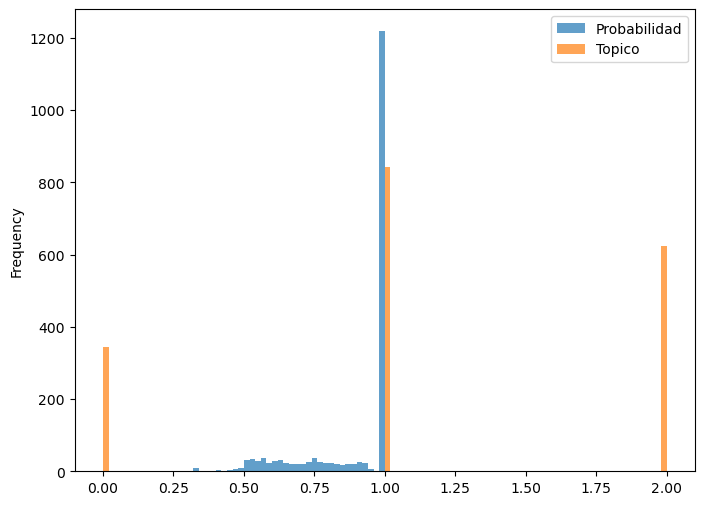

In [144]:
df_predicciones[['Probabilidad', 'Topico']].plot.hist(bins=100, figsize=(8,6), alpha=0.7)